# Final Evaluation Script – Pneumonia Detection using Transfer Learning (ResNet50)

**Task:** Binary classification of chest X-rays (Normal vs. Pneumonia)  
**Model:** ResNet50 with Transfer Learning  
**Dataset:** Custom-labeled X-ray dataset  
**Approach:** Fine-tuned last layers, froze early convolutional layers

### What this script does:
- Loads the best trained model (`best_model.pth`)
- Evaluates on the test set
- Generates precision, recall, F1-score (per class)
- Plots confusion matrices (raw counts and percentages)

---

### *Imports*

In [26]:
import torch
import torch.nn as nn
from torchvision.models import resnet50, ResNet50_Weights
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sys
from sklearn.metrics import roc_auc_score, roc_curve

In [39]:
# For Jupyter hot-reloading (optional, safe to remove if not needed)
%reload_ext autoreload
%autoreload 2

# Add the parent directory to sys.path to import 'scripts'
sys.path.append("..")

# Load Data
from scripts.data_preprocessing import test_loader

In [28]:
# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


### *Load base model with pretrained weights*

In [29]:
weights = ResNet50_Weights.DEFAULT
model = resnet50(weights=weights)

# Freeze all layers except layer3, layer4, and fc
for name, param in model.named_parameters():
    if "layer3" in name or "layer4" in name or "fc" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

# Replace final classifier layer
model.fc = nn.Sequential(
    nn.Linear(2048, 512),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(512, 2)  # Binary classification
)

# Load trained and best model weights
model.load_state_dict(torch.load("best_model.pth"))
model = model.to(device)
model.eval()

print(" Model loaded and ready for evaluation.")

 Model loaded and ready for evaluation.


## *Evaluation Function*

In [30]:
# Evaluates model
def evaluate_model(model, dataloader, device, class_names=["Normal", "Pneumonia"]):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)
            outputs = model(images)

            # Probability of class 1 (Pneumonia)
            probs = torch.softmax(outputs, dim=1)[:, 1]

            _, predicted = torch.max(outputs, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    return np.array(all_labels), np.array(all_preds), np.array(all_probs)

In [33]:
# Classification report
def print_classification_report(true_labels, pred_labels, class_names):
    report = classification_report(true_labels, pred_labels, target_names=class_names, output_dict=True)
    accuracy = report["accuracy"] * 100

    print(f"\nTest Accuracy: {accuracy:.2f}%\n")
    print("Classification Report (in %):\n")
    print(f"{'Class':<12} {'Precision':>10} {'Recall':>10} {'F1-Score':>10}")
    print("-" * 44)
    for label in class_names:
        precision = report[label]["precision"] * 100
        recall = report[label]["recall"] * 100
        f1 = report[label]["f1-score"] * 100
        print(f"{label:<12} {precision:10.2f} {recall:10.2f} {f1:10.2f}")
    print("-" * 44)
    macro_avg = report["macro avg"]
    weighted_avg = report["weighted avg"]
    print(f"{'Macro Avg':<12} {macro_avg['precision']*100:10.2f} {macro_avg['recall']*100:10.2f} {macro_avg['f1-score']*100:10.2f}")
    print(f"{'Weighted Avg':<12} {weighted_avg['precision']*100:10.2f} {weighted_avg['recall']*100:10.2f} {weighted_avg['f1-score']*100:10.2f}")

# Confusion Matrix
def plot_confusion_matrices(true_labels, pred_labels, class_names):
    cm = confusion_matrix(true_labels, pred_labels)

    # Raw Count Matrix
    print("\nConfusion Matrix (Raw Counts):\n")
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix (Raw Counts)")
    plt.tight_layout()
    plt.show()

    # Percent Matrix
    print("\nConfusion Matrix (as Percentages):\n")
    cm_percent = np.round(cm / cm.sum(axis=1, keepdims=True) * 100, 1)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm_percent, annot=True, fmt=".1f", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix (in %)")
    plt.tight_layout()
    plt.show()

# AUC
def plot_roc_auc(true_labels, pred_probs):
    fpr, tpr, thresholds = roc_curve(true_labels, pred_probs)
    auc_score = roc_auc_score(true_labels, pred_probs)

    print(f"\nAUC (Area Under ROC Curve): {auc_score:.4f}")

    plt.figure(figsize=(7, 6))
    plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}")
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic (ROC) Curve")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

## *Run Final Evaluation*


Test Accuracy: 95.09%

Classification Report (in %):

Class         Precision     Recall   F1-Score
--------------------------------------------
Normal            98.01      92.06      94.94
Pneumonia         92.51      98.13      95.24
--------------------------------------------
Macro Avg         95.26      95.09      95.09
Weighted Avg      95.26      95.09      95.09

Confusion Matrix (Raw Counts):



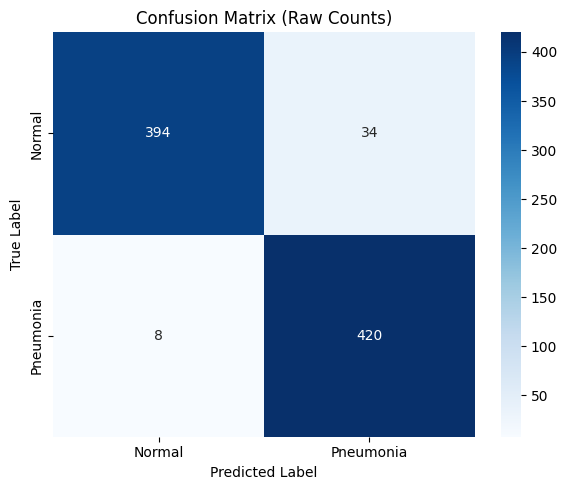


Confusion Matrix (as Percentages):



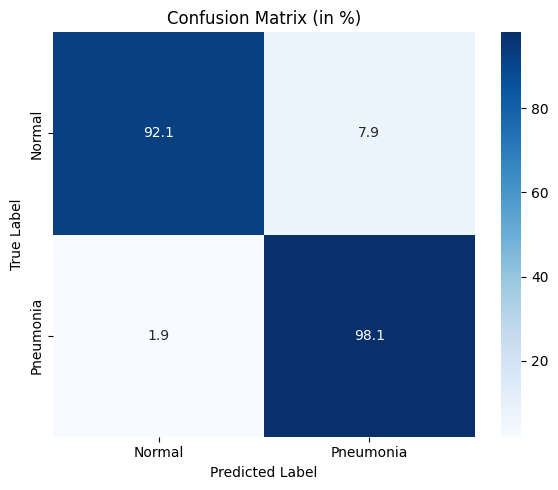


AUC (Area Under ROC Curve): 0.9884


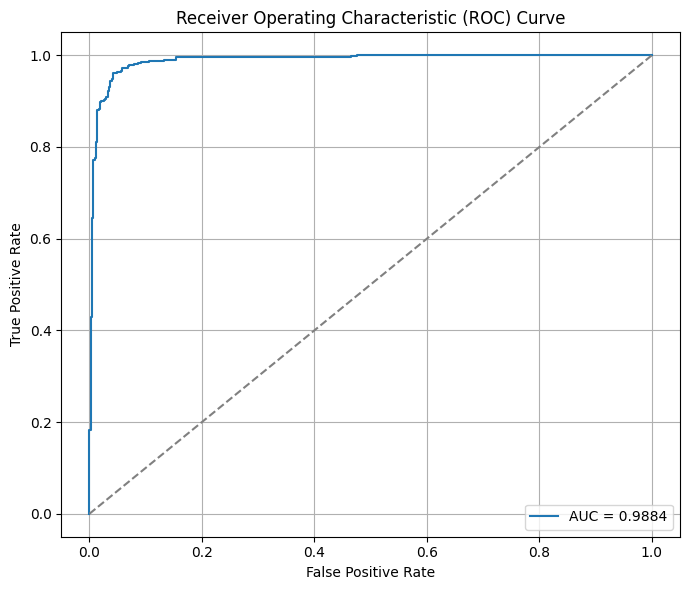

In [56]:
# Evaluate
true_labels, pred_labels, pred_probs = evaluate_model(model, test_loader, device)

# Print Report
print_classification_report(true_labels, pred_labels, class_names=["Normal", "Pneumonia"])

# Confusion Matrix
plot_confusion_matrices(true_labels, pred_labels, class_names=["Normal", "Pneumonia"])

# AUC and ROC
plot_roc_auc(true_labels, pred_probs)